# Logistic Regression


**Input** 

- n : the number of data point
- $mx_1$, $vx_1$, $my_1$, $vy_1$, $mx_2$, $vx_2$, $my_2$, $vy_2$

In [1]:

## a. Univariate Gaussian data generator
# - mean: $m$
# - Variance: $s$
# - handcraft gaussian distribution
#     - **Box-Muller transform**
#     - Ziggurat algorithm
# - np.random.uniform()

import numpy as np

def  univariate_Gaussian_data_generator(m,s):
    u1 = np.random.uniform(0,1)
    u2 = np.random.uniform(0,1)
    z = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    x = m + np.sqrt(s) * z
    return x


#print(univariate_Gaussian_data_generator(1.2204925277612,0))

# point = [ ma, va, mb, vb, mc, vc, md, vd]


def generate_data_point(n, point):

    d1x = [univariate_Gaussian_data_generator(point[0], point[4]) for _ in range(n)] #n(mx1,vx1)
    d1y = [univariate_Gaussian_data_generator(point[1], point[5]) for _ in range(n)] #n(my1,vy1)
    d2x = [univariate_Gaussian_data_generator(point[2], point[6]) for _ in range(n)]
    d2y = [univariate_Gaussian_data_generator(point[3], point[7]) for _ in range(n)]

    print(len(d1x))

    D1 = np.array([d1x, d1y]).T
    D2 = np.array([d2x, d2y]).T

    return D1, D2

def prepare_dataset(D1, D2):
    X = np.vstack((D1, D2))
    y = np.array([0] * len(D1) + [1] * len(D2)).reshape(-1, 1)

    return X, y



In [11]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_hessian(X, w):
    h = sigmoid(X @ w)
    S = np.diag((h * (1 - h)).flatten())
    return X.T @ S @ X

def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])


def logistic_regression_newtonmethod(X, y, max_iter=1000, tol=1e-6, lr=0.01):
    n_samples, n_features = X.shape
    w = np.zeros((n_features, 1))
    for i in range(max_iter):
        z = X @ w
        h = sigmoid(z)
        grad = X.T @ (y - h)
        H = compute_hessian(X, w)
        try:
            delta = np.linalg.solve(H, grad)
        except np.linalg.LinAlgError:
            print("Hessian is singular. Using steepest gradient descent instead.")
            delta = grad
        update = lr * delta
        w += update
        if np.linalg.norm(update) < tol:
            print(f"Converged in {i+1} iterations.")
            break

    return w


def logistic_regression_gradientdescent(X, y, max_iter=10000, tol=1e-6, lr=0.01):

    n_samples, n_features = X.shape
    w = np.zeros((n_features, 1))

    for t in range(max_iter):
        grad = X.T @ (y - sigmoid(X @ w))
        w += lr * grad


        if np.linalg.norm(grad) < tol:
            print(f"Converged in {t+1} iterations.")
            break


    return w



def predict(X, w):

    return (sigmoid(X@w) >= 0.5).astype(int)


def confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    return TP, TN, FP, FN


def evaluate(y_true, y_pred):
    TP, TN, FP, FN = confusion_matrix(y_true, y_pred)
    sensitivity = TP / (TP+FN) # 所有positive中模型預測正確比率
    specificity = TN / (TN+FP) # 所有negative中模型預測正確比率
    accuracy =  (TP+TN)/(TP + TN + FP + FN)

    matrix = f"""
Confusion Matrix:
                 Predict cluster 1   Predict cluster 2
Is cluster 1         {TN:<10}           {FP:<10}
Is cluster 2         {FN:<10}           {TP:<10}

Sensitivity (Successfully predict cluster 2): {sensitivity:.5f}
Specificity (Successfully predict cluster 1): {specificity:.5f}
Accuracy : {accuracy * 100:.2f}%
"""
    print(matrix)


#D1, D2  = generate_data_point(50, [1,1,10,10,2,2,2,2])
D1, D2  = generate_data_point(50, [1,1,3,3,2,2,4,4])
X, y = prepare_dataset(D1, D2)
X = add_bias(X)  # 加 bias 項

print(X.shape, y.shape)

w_gd = logistic_regression_gradientdescent(X, y, max_iter=1000, tol=0.1, lr=0.01)
print("Gradient descent:")
print(w_gd)



y_pred_gd = predict(X, w_gd)
evaluate(y_pred_gd.flatten(), y.flatten())


w_n = logistic_regression_newtonmethod(X, y, max_iter=1000, tol=0.1, lr=0.01)
print("Newton's method:")
print(w_n)

y_pred_n = predict(X, w_n)
evaluate(y_pred_n.flatten(), y.flatten())




50
(100, 3) (100, 1)
Converged in 117 iterations.
Gradient descent:
[[-2.41234429]
 [ 0.72396734]
 [ 0.57692568]]

Confusion Matrix:
                 Predict cluster 1   Predict cluster 2
Is cluster 1         38                   13        
Is cluster 2         12                   37        

Sensitivity (Successfully predict cluster 2): 0.75510
Specificity (Successfully predict cluster 1): 0.74510
Accuracy : 75.00%

Converged in 1 iterations.
Newton's method:
[[-0.01604618]
 [ 0.00455925]
 [ 0.00366804]]

Confusion Matrix:
                 Predict cluster 1   Predict cluster 2
Is cluster 1         40                   13        
Is cluster 2         10                   37        

Sensitivity (Successfully predict cluster 2): 0.78723
Specificity (Successfully predict cluster 1): 0.75472
Accuracy : 77.00%



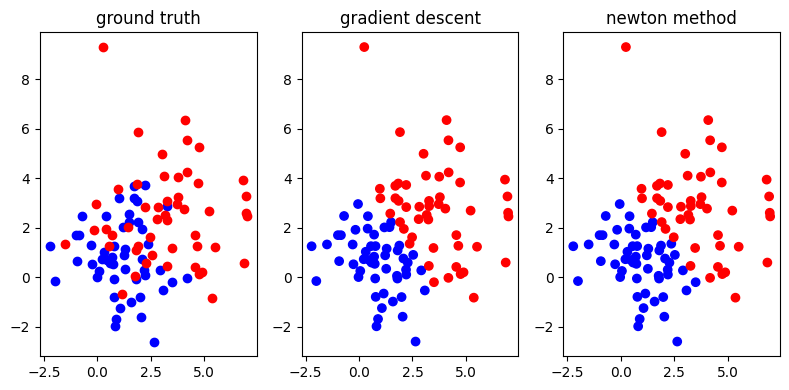

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(8, 4))  # 建立1x3子圖

axs[0].scatter(D1[:, 0], D1[:, 1], c='blue', label='Cluster 1')
axs[0].scatter(D2[:, 0], D2[:, 1], c='red', label='Cluster 2')
axs[0].set_title("ground truth")

axs[1].scatter(X[:, 1], X[:, 2], c=y_pred_gd, cmap='bwr')
axs[1].set_title("gradient descent")

axs[2].scatter(X[:, 1], X[:, 2], c=y_pred_n, cmap='bwr')
axs[2].set_title("newton method")

plt.tight_layout()
plt.show()


# EM algorithm

In [4]:
import struct
import numpy as np

def read_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        print(format(file_path))
        print("Magic Number:", magic)
        print("Number of Images:", num_images)
        print("Image Dimensions: {}x{}".format(num_rows, num_cols))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)

    return images

def read_mnist_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num_labels= struct.unpack('>II', f.read(8))
        print(format(file_path))
        print("Magic Number:", magic)
        print("Number of Labels:", num_labels)
        labels = np.fromfile(f, dtype=np.uint8)
    return labels


train_images_path = 'train-images.idx3-ubyte__'
test_images_path = 't10k-images.idx3-ubyte__'
train_labels_path = 'train-labels.idx1-ubyte__'
test_labels_path = 't10k-labels.idx1-ubyte__'

train_images = read_mnist_images(train_images_path)
test_images = read_mnist_images(test_images_path)
train_labels = read_mnist_labels(train_labels_path)
test_labels = read_mnist_labels(test_labels_path)

print(train_images.shape)
print(test_images.shape)



train-images.idx3-ubyte__
Magic Number: 2051
Number of Images: 60000
Image Dimensions: 28x28
t10k-images.idx3-ubyte__
Magic Number: 2051
Number of Images: 10000
Image Dimensions: 28x28
train-labels.idx1-ubyte__
Magic Number: 2049
Number of Labels: 60000
t10k-labels.idx1-ubyte__
Magic Number: 2049
Number of Labels: 10000
(60000, 28, 28)
(10000, 28, 28)


In [5]:
def assign_label(true_labels, w):
    cluster_labels = np.argmax(w, axis=1)
    table = np.zeros((10, 10), dtype=int)

    for i in range(len(true_labels)):
        table[true_labels[i], cluster_labels[i]] += 1

    mapping = {}
    used_clusters = set()
    for _ in range(10):
        i, j = divmod(np.argmax(table), 10)
        mapping[j] = i  # cluster j → digit i
        table[i, :] = -1
        table[:, j] = -1
        used_clusters.add(j)

    for cluster in range(10):
        if cluster not in mapping:
            mapping[cluster] = -1  # or assign -1 表示無效

    return mapping


def print_fig(p, mapping):
    # 建立 label → cluster 的反向 mapping
    label_to_cluster = {label: cluster for cluster, label in mapping.items()}

    p_img = p.reshape(10, 28, 28)

    for label in range(10):
        if label not in label_to_cluster:
            print(f"{label}: [No cluster assigned]")
            print()
            continue

        cluster = label_to_cluster[label]
        image = p_img[cluster]
        print(f'{label} (cluster {cluster}):')
        for j in range(28):
            for k in range(28):
                print('1' if image[j, k] > 0.5 else '0', end=' ')
            print()
        print()



In [6]:
def binarize_image(images):
    return (images >= 128).astype(np.float32)


def e_step(images, p, pi, num_cluster):
    num, D = images.shape # D維 28*28 784
    w = np.zeros((num, num_cluster))
    for k in range(num_cluster):
        prob = np.prod(p[k]**images * (1 - p[k])**(1 - images), axis=1)
        w[:, k] = pi[k] * prob
    w /= np.sum(w, axis=1, keepdims=True)  # normalize
    return w

def m_step(images, w, num_cluster):
    num, D = images.shape
    pi = np.sum(w, axis=0) / num
    p = np.dot(w.T, images) / np.sum(w, axis=0)[:, np.newaxis]
    return p, pi

def em_algorithm(image, true_labels, max_iter=20, tol=0.1):
    num , D = image.shape
    num_cluster = 10

    # Initialize parameters
    p = np.random.rand(num_cluster, D) * 0.5 + 0.25
    p = np.clip(p, 1e-2, 1 - 1e-2)  # 將所有機率限制在 [0.01, 0.99] 之間
    pi = np.ones(num_cluster) / num_cluster

    for i in range(max_iter):
        print(f"Iteration {i+1}/{max_iter}")

        # E-step
        w = e_step(image, p, pi, num_cluster)

        # M-step
        p, pi = m_step(image, w, num_cluster)

        mapping = assign_label(true_labels, w)
        print_fig(p, mapping)

        # Check convergence
        if i > 0 and np.linalg.norm(p - p_prev) < tol:
            print(f"Converged in {i} iterations.")
            break
        p_prev = p.copy()


    total_iterations = i + 1
    cluster_ids = np.argmax(w, axis=1)
    predicted_digits = np.array([mapping.get(c, -1) for c in cluster_ids])
    valid_mask = predicted_digits != -1
    error_rate = np.mean(predicted_digits[valid_mask] != true_labels[valid_mask])

    print(f"Total iteration to converge: {total_iterations}")
    print(f"Total error rate: {error_rate:.6f}")

    return p, pi, w




image_flat = train_images.reshape(-1,28*28)
images_bin = binarize_image(image_flat)
p, pi, w = em_algorithm(images_bin, train_labels, max_iter=20, tol=0.1)

predicted_labels = np.argmax(w, axis=1)


Iteration 1/20
0 (cluster 8):
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 
0

In [7]:
# predicted_digits[0]

# print(f'pic 0 predicted -> {predicted_digits[0]} :')
# for j in range(28):
#     for k in range(28):
#         print('1' if train_images[0, j, k] > 0 else '0', end=' ')
#     print()




In [8]:
import matplotlib.pyplot as plt

def show_em_digit_templates(p, mapping=None):
    p_img = p.reshape(10, 28, 28)
    fig, axs = plt.subplots(2, 5, figsize=(10, 5))
    for cluster in range(10):
        ax = axs[cluster // 5, cluster % 5]
        ax.imshow(p_img[cluster], cmap='gray')
        label = mapping[cluster] if mapping is not None else cluster
        ax.set_title(f"Cluster {cluster} → {label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# show_em_digit_templates(p, mapping)

In [9]:
def confusion_matrix_binary(y_true, y_pred, target_digit):
    TP = np.sum((y_true == target_digit) & (y_pred == target_digit))
    TN = np.sum((y_true != target_digit) & (y_pred != target_digit))
    FP = np.sum((y_true != target_digit) & (y_pred == target_digit))
    FN = np.sum((y_true == target_digit) & (y_pred != target_digit))
    return TP, TN, FP, FN


def evaluate_all_digits(y_true, y_pred):
    for digit in range(10):
        TP, TN, FP, FN = confusion_matrix_binary(y_true, y_pred, digit)
        sensitivity = TP / (TP + FN) if TP + FN > 0 else 0
        specificity = TN / (TN + FP) if TN + FP > 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN)

        matrix = f"""
------------------------------------------------------------------------------
Confusion Matrix {digit}:
                 Predict {digit}     Predict not {digit}
Is {digit}           {TP:<10}        {FN:<10}
Isn't {digit}        {FP:<10}        {TN:<10}

Sensitivity (Successfully predict number {digit})     : {sensitivity:.5f}
Specificity (Successfully predict not number {digit}) : {specificity:.5f}
Accuracy                                               : {accuracy * 100:.2f}%
"""
        print(matrix)
evaluate_all_digits(train_labels, predicted_labels)



------------------------------------------------------------------------------
Confusion Matrix 0:
                 Predict 0     Predict not 0
Is 0           96                5827      
Isn't 0        5811              48266     

Sensitivity (Successfully predict number 0)     : 0.01621
Specificity (Successfully predict not number 0) : 0.89254
Accuracy                                               : 80.60%


------------------------------------------------------------------------------
Confusion Matrix 1:
                 Predict 1     Predict not 1
Is 1           34                6708      
Isn't 1        8567              44691     

Sensitivity (Successfully predict number 1)     : 0.00504
Specificity (Successfully predict not number 1) : 0.83914
Accuracy                                               : 74.54%


------------------------------------------------------------------------------
Confusion Matrix 2:
                 Predict 2     Predict not 2
Is 2           11        

In [10]:
mapping = assign_label(train_labels, w)
print_fig(p, mapping)

0 (cluster 6):
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 1 1 